<h1 style="color: orange;">Comparison of Models Trained with One‑Hot vs. Target Encoding</h1>

<h2 style="color: green;">Introduction</h2>
<p style="color: gray;">
In this notebook, we compare a suite of models trained on the SBA Financial dataset using two different encoding schemes for categorical features:
</p>

<ul style="color: gray;">
  <li><strong>One‑Hot Encoding Models:</strong> RandomForest, GradientBoosting, and XGBoost.</li>
  <li><strong>Target Encoding Models:</strong> DummyClassifier, Logistic Regression, RandomForest, GradientBoosting, XGBoost, CatBoost, and LightGBM.</li>
</ul>

<p style="color: gray;">
The objective is to evaluate these models on a common test set using metrics such as ROC AUC, confusion matrices, and classification reports. We will also plot a combined ROC curve to visually compare their performance.
</p>

<h2 style="color: green;">Objectives</h2>
<ul style="color: gray;">
  <li>Load pre‑trained models from two separate directories.</li>
  <li>Generate predictions on the same test set.</li>
  <li>Compute evaluation metrics (ROC AUC, confusion matrices, classification reports).</li>
  <li>Plot a combined ROC curve for all models.</li>
  <li>Discuss the differences between the encoding schemes and their impact on model performance.</li>
</ul>

<h2 style="color: green;">Let's Get Started!</h2>


In [1]:
#Data Manipulation
import os
import pickle
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data modelization
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,roc_curve, auc,ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
import shap
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import warnings

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pickle
import numpy as np

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Intercept references to the MT19937 bit generator from both modules.
        if module in ["numpy.random._pickle", "numpy.random._mt19937"] and name == "MT19937":
            return np.random.MT19937
        return super().find_class(module, name)

def custom_load(path):
    with open(path, "rb") as f:
        return CustomUnpickler(f).load()

# Define the directories for each encoding scheme
oh_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/OH/'
te_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/'

# Define model file names for each scheme. Adjust these filenames as needed.
oh_model_files = {
    "RF_OH": "RandomForest_best_random_oh_model.pkl",
    "XGB_OH": "XGBoost_best_random_oh_model.pkl",
    "GB_OH": "GradientBoosting_best_random_oh_model.pkl"
}

te_model_files = {
   "Dummy_TE": "best_dummy_model.pkl",
    "LogReg_TE": "logistic_regression_best_grid_model.pkl",
    "RF_TE": "RandomForest_best_grid_model.pkl",
    "XGB_TE": "XGBoost_best_grid_model.pkl",
    "CatBoost_TE": "catboost_best_grid_model.pkl",
    "LGBM_TE": "lightgbm_best_grid_model.pkl",
    "GB_TE": "GradientBoosting_best_grid_model.pkl"
}

def load_models(directory, model_files):
    models = {}
    for name, filename in model_files.items():
        path = os.path.join(directory, filename)
        models[name] = custom_load(path)
        print(f"Loaded {name} from {path}")
    return models

# Load models from the respective directories.
te_models = load_models(te_dir, te_model_files)
oh_models = load_models(oh_dir, oh_model_files)

# Combine into one dictionary for comparison.
all_models = {**oh_models, **te_models}


Loaded Dummy_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/best_dummy_model.pkl
Loaded LogReg_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/logistic_regression_best_grid_model.pkl
Loaded RF_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/RandomForest_best_grid_model.pkl
Loaded XGB_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/XGBoost_best_grid_model.pkl
Loaded CatBoost_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/catboost_best_grid_model.pkl
Loaded LGBM_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/lightgbm_best_grid_model.pkl
Loaded GB_TE from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/GradientBoosting_best_grid_model.pkl
Loaded RF_OH from /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/OH/RandomForest

In [3]:
#Loading my dataset 
with open("/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/exp_data.pkl", "rb") as f:
    df = pickle.load(f, fix_imports=True)
    
print(df.head(2))
df.info()


  State    Zip BankState  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
0    IN  47711        OH        1997    84      4       1.0          0   
1    IN  46526        IN        1997    60      2       1.0          0   

   RetainedJob  FranchiseCode  UrbanRural  RevLineCr  LowDoc  \
0            0              0           0        0.0     1.0   
1            0              0           0        0.0     1.0   

   DisbursementGross  MIS_Status   GrAppv ApprovalMonth NAICS_CODE  
0            60000.0           0  60000.0             2         45  
1            40000.0           0  40000.0             2         72  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              899162 non-null  object 
 1   Zip                899164 non-null  object 
 2   BankState          897598 non-null  object 
 3   ApprovalFY      

In [4]:
#  Define a helper function to convert binary columns
def convert_binary(X):
    X = X.copy()
    binary_cols = ["RevLineCr", "LowDoc", "NewExist"]
    for col in binary_cols:
        if col in X.columns:
            X[col] = X[col].astype(int)
    return X
# --- Data Preparation ---
target = "MIS_Status"
X = df.drop(columns=[target])
y = df[target]

# Columns to impute (example columns)
cols_to_impute = ['State','RevLineCr', 'LowDoc', 'BankState', 'NewExist']
imputer = SimpleImputer(strategy='most_frequent')
X[cols_to_impute] = imputer.fit_transform(X[cols_to_impute])
# Assuming X is your feature DataFrame
X = convert_binary(X)

# Then split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Identify categorical columns (for target encoding)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# **Convert categorical columns to category dtype**
for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [5]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import numpy as np


results = {}

for name, model in all_models.items():

    try:
        # Try to use predict_proba for ROC; if not available, use decision_function or predictions.
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    except Exception:
        y_pred_proba = np.array(model.predict(X_test))
    
    y_pred = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "auc": auc_score,
        "report": report,
        "cm": cm,
        "fpr_tpr": roc_curve(y_test, y_pred_proba)  # returns (fpr, tpr, thresholds)
    }
    print(f"{name} AUC: {auc_score:.4f}")


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RF_OH AUC: 0.9034


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGB_OH AUC: 0.9744


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GB_OH AUC: 0.9760
Dummy_TE AUC: 0.5000


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

LogReg_TE AUC: 0.8370
RF_TE AUC: 0.9392
XGB_TE AUC: 0.9755
CatBoost_TE AUC: 0.9757
LGBM_TE AUC: 0.9799
GB_TE AUC: 0.9781


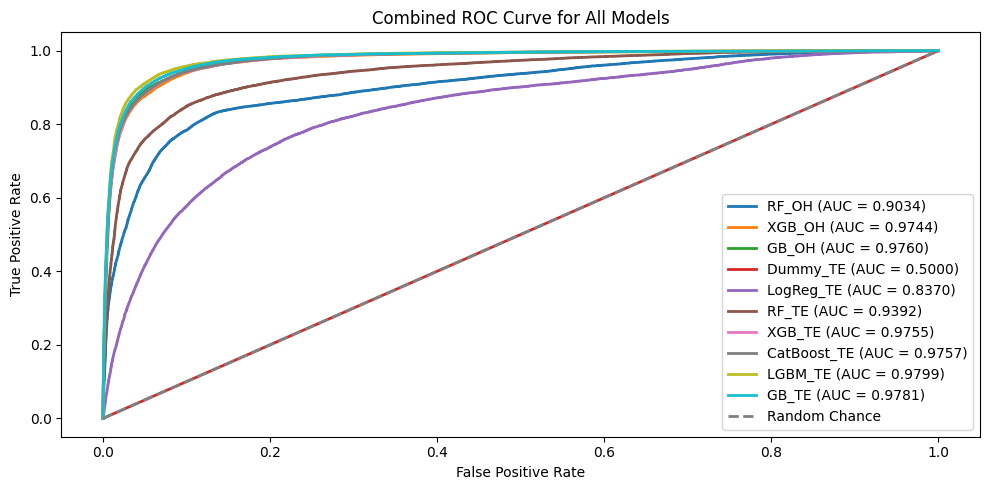

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for name, res in results.items():
    fpr, tpr, _ = res["fpr_tpr"]
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {res['auc']:.4f})")

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve for All Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


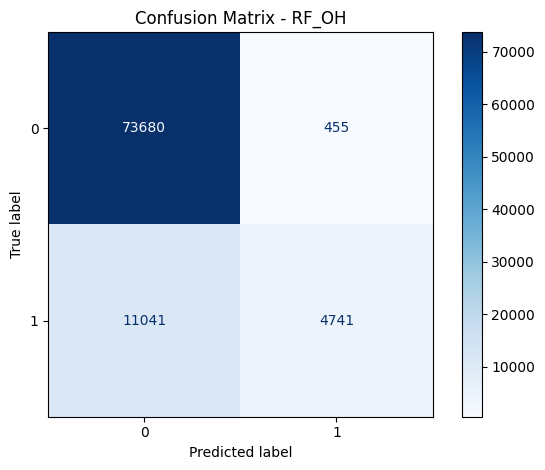

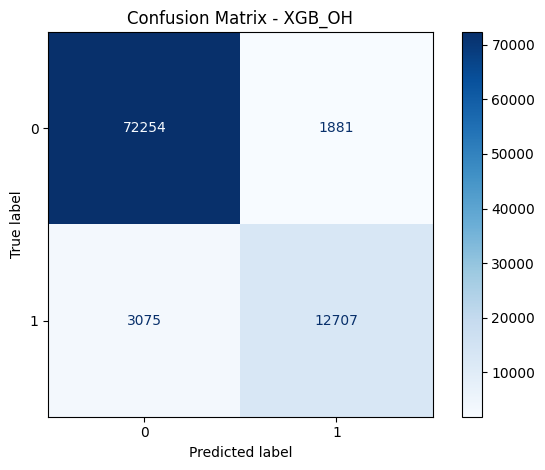

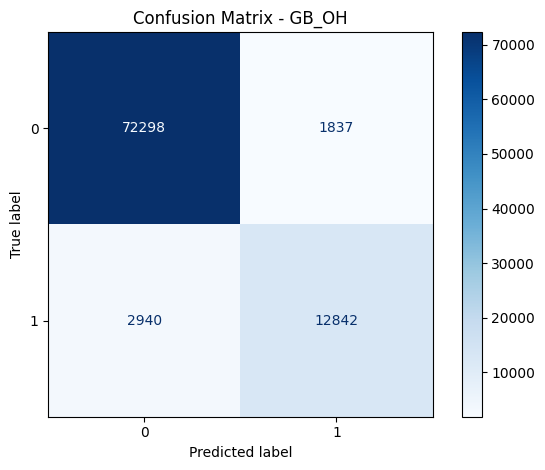

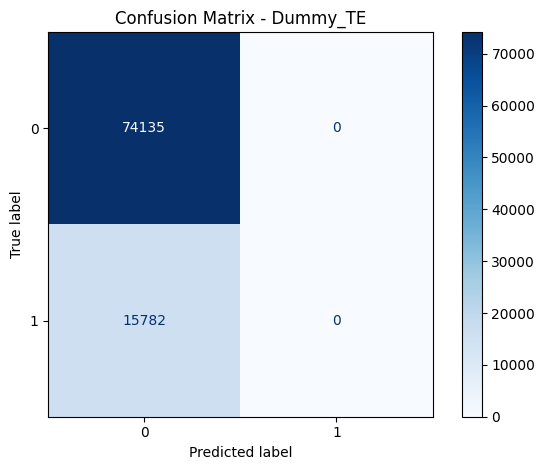

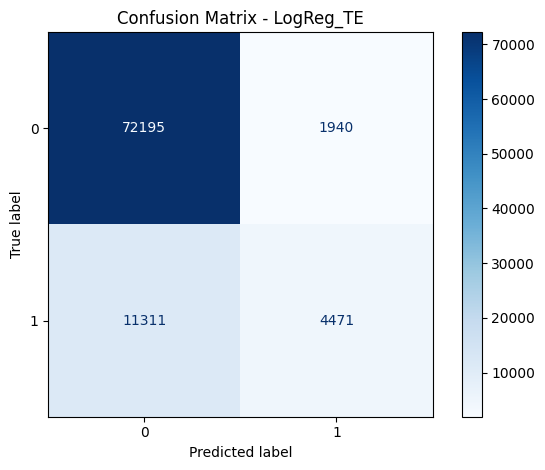

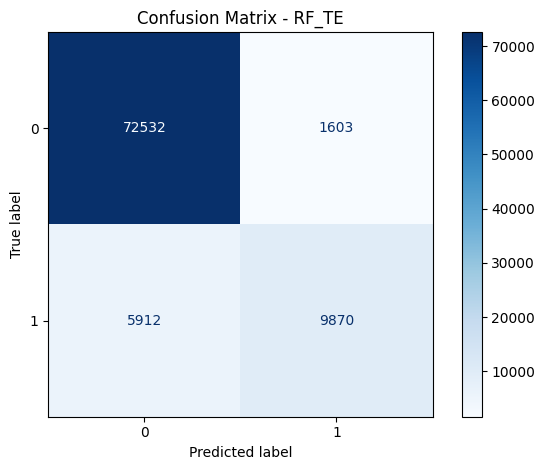

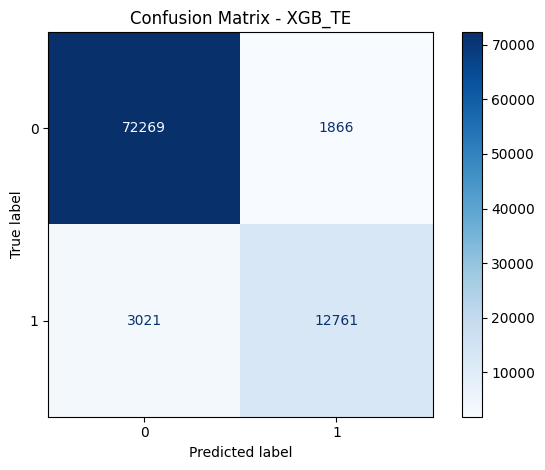

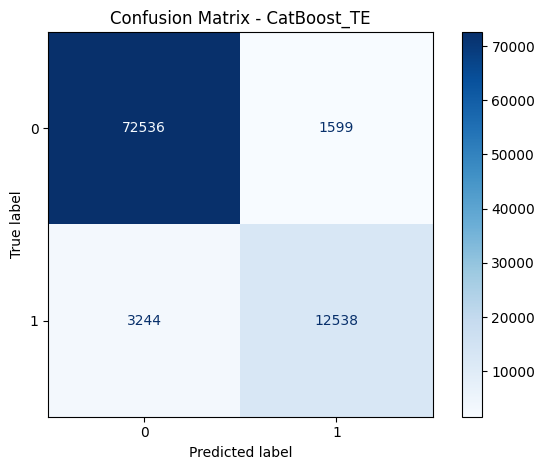

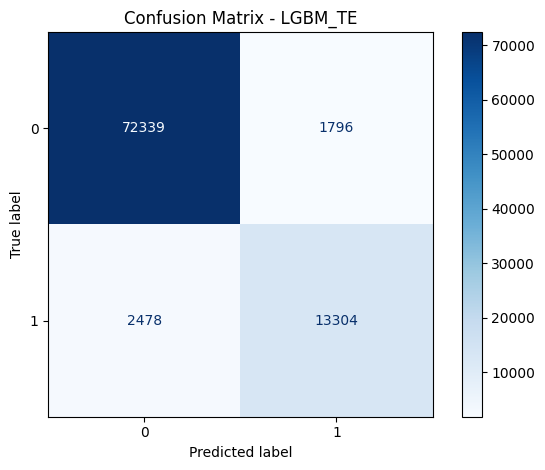

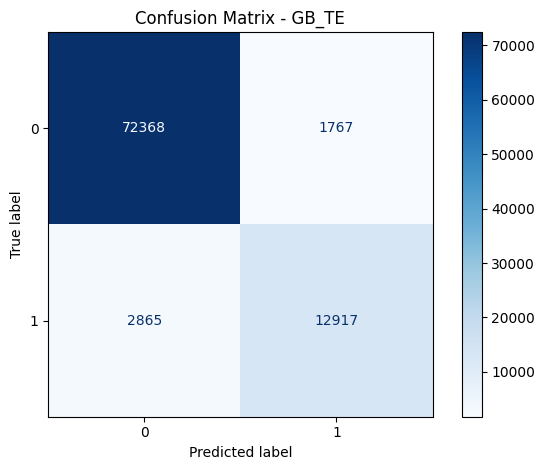

In [7]:
for name, res in results.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=res["cm"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()


In [8]:
for name, res in results.items():
    print(f"Classification Report for {name}:")
    print(pd.DataFrame(res["report"]).transpose())
    print("\n")


Classification Report for RF_OH:
              precision    recall  f1-score       support
0              0.869678  0.993863  0.927633  74135.000000
1              0.912433  0.300406  0.451997  15782.000000
accuracy       0.872149  0.872149  0.872149      0.872149
macro avg      0.891055  0.647134  0.689815  89917.000000
weighted avg   0.877182  0.872149  0.844150  89917.000000


Classification Report for XGB_OH:
              precision    recall  f1-score       support
0              0.959179  0.974627  0.966842  74135.000000
1              0.871058  0.805158  0.836813  15782.000000
accuracy       0.944883  0.944883  0.944883      0.944883
macro avg      0.915119  0.889893  0.901827  89917.000000
weighted avg   0.943712  0.944883  0.944019  89917.000000


Classification Report for GB_OH:
              precision    recall  f1-score       support
0              0.960924  0.975221  0.968020  74135.000000
1              0.874855  0.813712  0.843177  15782.000000
accuracy       0.946873  0

In [9]:
import pandas as pd

# Suppose you've built a 'results' dictionary for your models.
def interpret_recall(recall):
    if recall < 0.4:
        return "Low recall: many positives missed."
    elif recall < 0.7:
        return "Moderate recall."
    else:
        return "High recall: most positives captured."

def interpret_precision(precision):
    if precision < 0.4:
        return "Low precision: many false positives."
    elif precision < 0.7:
        return "Moderate precision."
    else:
        return "High precision: predictions are reliable."

def overall_interpretation(recall, precision):
    if recall >= 0.7 and precision >= 0.7:
        return "Balanced and strong performance."
    elif recall < 0.4 and precision < 0.4:
        return "Poor performance overall."
    elif recall < 0.4:
        return "Very low recall despite moderate/high precision."
    elif precision < 0.4:
        return "Very low precision despite moderate/high recall."
    else:
        return "Mixed performance."

rows = []
for name, res in results.items():
    report = res["report"]
    accuracy = report.get("accuracy", None)
    macro = report.get("macro avg", {})
    f1_macro = macro.get("f1-score", None)
    recall_macro = macro.get("recall", None)
    precision_macro = macro.get("precision", None)
    
    rows.append({
        "Model_Name": name,
        "AUC": res["auc"],
        "F1 Macro": f1_macro,
        "Accuracy": accuracy,
        "Recall": recall_macro,
        "Precision": precision_macro,
        "Recall Interpretation": interpret_recall(recall_macro),
        "Precision Interpretation": interpret_precision(precision_macro),
        "Overall Interpretation": overall_interpretation(recall_macro, precision_macro)
    })

summary_df = pd.DataFrame(rows).sort_values(by="AUC", ascending=False)
summary_df


,Model_Name,AUC,F1 Macro,Accuracy,Recall,Precision,Recall Interpretation,Precision Interpretation,Overall Interpretation
8,LGBM_TE,0.979936,0.916454,0.952467,0.909380,0.923969,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
9,GB_TE,0.978116,0.908476,0.948486,0.897315,0.920792,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
2,GB_OH,0.976008,0.905598,0.946873,0.894466,0.917890,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
7,CatBoost_TE,0.975659,0.902912,0.946139,0.886440,0.922042,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
6,XGB_TE,0.975458,0.903293,0.945650,0.891705,0.916151,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
1,XGB_OH,0.974436,0.901827,0.944883,0.889893,0.915119,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
5,RF_TE,0.939230,0.837509,0.916423,0.801887,0.892457,High recall: most positives captured.,High precision: predictions are reliable.,Balanced and strong performance.
0,RF_OH,0.903385,0.689815,0.872149,0.647134,0.891055,Moderate recall.,High precision: predictions are reliable.,Mixed performance.
4,LogReg_TE,0.836993,0.659431,0.852631,0.628564,0.780972,Moderate recall.,High precision: predictions are reliable.,Mixed performance.
3,Dummy_TE,0.500000,0.451899,0.824483,0.500000,0.412241,Moderate recall.,Moderate precision.,Mixed performance.


In [11]:
#Exporting my interpretation to excel 
summary_df.to_csv('/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/interpretations.csv', index=False)

In [13]:
#Pipeline of each model 
for model_name, pipeline in all_models.items():
    print(f"----- {model_name} -----")
    # Afficher les étapes du pipeline
    print("Pipeline steps:")
    print(pipeline)
    
    # Afficher les paramètres du classifieur (la partie 'classifier')
    params = pipeline.get_params()
    print("\nClassifier parameters:")
    for key, value in params.items():
        if key.startswith("classifier"):
            print(f"{key}: {value}")
    print("-" * 50)


----- RF_OH -----
Pipeline steps:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['BankState', 'ApprovalMonth',
                                                   'NAICS_CODE'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=154,
                                        random_state=42))])

Classifier parameters:
classifier: RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=154, rand

<h2 style="color: green;">Conclusion</h2>
<p style="color: gray;">
Based on the combined ROC curve and detailed metrics (confusion matrices and classification reports), we can see that [LightGBM] achieved the highest AUC and provided a good balance between sensitivity and specificity. In contrast, the DummyClassifier serves as a baseline and confirms that our more advanced models significantly outperform a naive strategy.
</p>
<p style="color: gray;">
Future work may include further hyperparameter tuning, exploring ensemble techniques, or incorporating additional feature engineering to further boost performance.
</p>
